In [80]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import time
from matplotlib import colors as mcolours
plt.style.use('ggplot')
%matplotlib inline

In [81]:
%load_ext autoreload
%autoreload 1
%aimport graphing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [78]:
from numpy.random import RandomState
def get_rng():
    return RandomState(42)

In [38]:
xvector_dim = 512
lang_names = ["AR", "BG", "CH", "CR", "CZ", "FR", "GE", "JA", "KO", "PL", 
              "PO", "RU", "SP", "SW", "TA", "TH", "TU", "WU", "VN"]

lang_names_by_family = ["BG", "CR", "CZ", "PL", "RU", 
                        "FR", "PO", "SP", 
                        "CH", "WU", 
                        "GE", "SW", 
                        "AR", "JA", "KO", "TA", "TH", "TU", "VN"]

# slavic: "o"
# semitic: "v"
# sinitic: "P"
# italic: "*"
# germanic: "p"
# japonic: "X"
# koreanic: "d"
# tamil: "s"
# kra-dai: "<"
# turkic: "^"
# vietic: ">"

lang_properties = {
    "AR": ["dark sage",    "v"],
    "BG": ["aquamarine",   "o"],
    "CH": ["indigo",       "P"],
    "CR": ["brick red",    "o"],
    "CZ": ["sandy brown",  "o"],
    "FR": ["gray",         "*"],
    "GE": ["dark green",   "p"],
    "JA": ["dark peach",   "X"],
    "KO": ["salmon",       "d"],
    "PL": ["gold",         "o"],
    "PO": ["green yellow", "*"],
    "RU": ["dark orange",  "o"],
    "SP": ["navy blue",    "*"],
    "SW": ["black",        "p"],
    "TA": ["red",          "s"],
    "TH": ["hot pink",     "<"],
    "TU": ["dark red",     "^"],
    "WU": ["steel blue",   "P"],
    "VN": ["brown orange", ">"]
}

feat_cols = [str(i+1) for i in range(xvector_dim)]
col_names = ["language"] + feat_cols

In [39]:
def read_xvectors(filepath, xvector_dim=512):
    feat_cols = [str(i+1) for i in range(xvector_dim)]
    col_names = ["language"] + feat_cols
    df = pd.read_csv(filepath, sep=';', names=col_names)
    return df

In [40]:
def do_pca(df, n_comps=100, xvector_dim=512):
    feat_cols = [str(i+1) for i in range(xvector_dim)]
    col_names = ["language"] + feat_cols
    pca = PCA(n_components=n_comps, random_state=get_rng())
    pca_result = pca.fit_transform(df[feat_cols].values)
    print('Cumulative explained variation for {} principal components: {:.3f}'\
          .format(n_comps, np.sum(pca.explained_variance_ratio_)))

    pca_cols = []
    for i in range(n_comps):
        idx = "pca" + str(i)
        pca_cols.append(idx)
        df[idx] = pca_result[:,i]
    
    return df, pca_cols

In [41]:
def do_tsne(df, row_selector, cols, num_samples=None):
    if num_samples is None:
        num_samples = len(row_selector)
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=get_rng())
    tsne_results = tsne.fit_transform(df.loc[row_selector[:num_samples], cols].values)
    print('t-SNE done! Time elapsed: {:.1f} seconds'.format(time.time()-time_start))
    df_tsne = df.loc[row_selector[:num_samples],:].copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    return df_tsne

In [85]:
def plot_tsne(df, lang_names):
    colour_mapping = mcolours.get_named_colors_mapping()
    colours = [colour_mapping["xkcd:" + lang_properties[l][0]] for l in lang_names]
    markers = [lang_properties[l][1] for l in lang_names]

    plt.figure(figsize=(12, 12), frameon=True)
    ax = plt.gca()
    plot = sns.scatterplot(x='x-tsne', y='y-tsne', hue="language", data=df, 
                           palette=colours, hue_order=lang_names, style="language", 
                           markers=markers, style_order=lang_names, s=55, 
                           edgecolor="#dddddd00", linewidth=0.2, alpha=0.8, ax=ax)

    ax = graphing.style_axis(ax)
    ax.tick_params(axis='both', which='both', size=6, labelcolor='black', 
                   color='black', labelsize=graphing.font_size)
    
    
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles=handles[1:], labels=labels[1:], loc=0, frameon=1, 
                       prop={'size': graphing.font_size}, handletextpad=0.01, columnspacing=0.01)
    
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.tight_layout()
    legend.set_title("")
    fig = plot.get_figure()
    return fig

In [43]:
exps = ["mfcc_deltas_pitch_energy", "mfcc_deltas", "pitch_energy"]
data_to_plot = {}

In [44]:
for exp in exps:
    dim = 1024 if exp == "mfcc_deltas_pitch_energy" else 512
    filepath = "xvectors/{}_test/xvector.scp.csv".format(exp)
    df = read_xvectors(filepath, xvector_dim=dim)
    
    rndperm = get_rng().permutation(df.shape[0])
    df, pca_cols = do_pca(df,xvector_dim=dim)

#     rndperm = get_rng().permutation(100)
#     df, pca_cols = do_pca(df,xvector_dim=dim, n_comps=20)
    
    df = do_tsne(df, rndperm, pca_cols)
    data_to_plot[exp] = df

Cumulative explained variation for 100 principal components: 0.981
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 18663 samples in 0.126s...
[t-SNE] Computed neighbors for 18663 samples in 68.732s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18663
[t-SNE] Computed conditional probabilities for sample 2000 / 18663
[t-SNE] Computed conditional probabilities for sample 3000 / 18663
[t-SNE] Computed conditional probabilities for sample 4000 / 18663
[t-SNE] Computed conditional probabilities for sample 5000 / 18663
[t-SNE] Computed conditional probabilities for sample 6000 / 18663
[t-SNE] Computed conditional probabilities for sample 7000 / 18663
[t-SNE] Computed conditional probabilities for sample 8000 / 18663
[t-SNE] Computed conditional probabilities for sample 9000 / 18663
[t-SNE] Computed conditional probabilities for sample 10000 / 18663
[t-SNE] Computed conditional probabilities for sample 11000 / 18663
[t-SNE] Computed conditional probabilities for sa

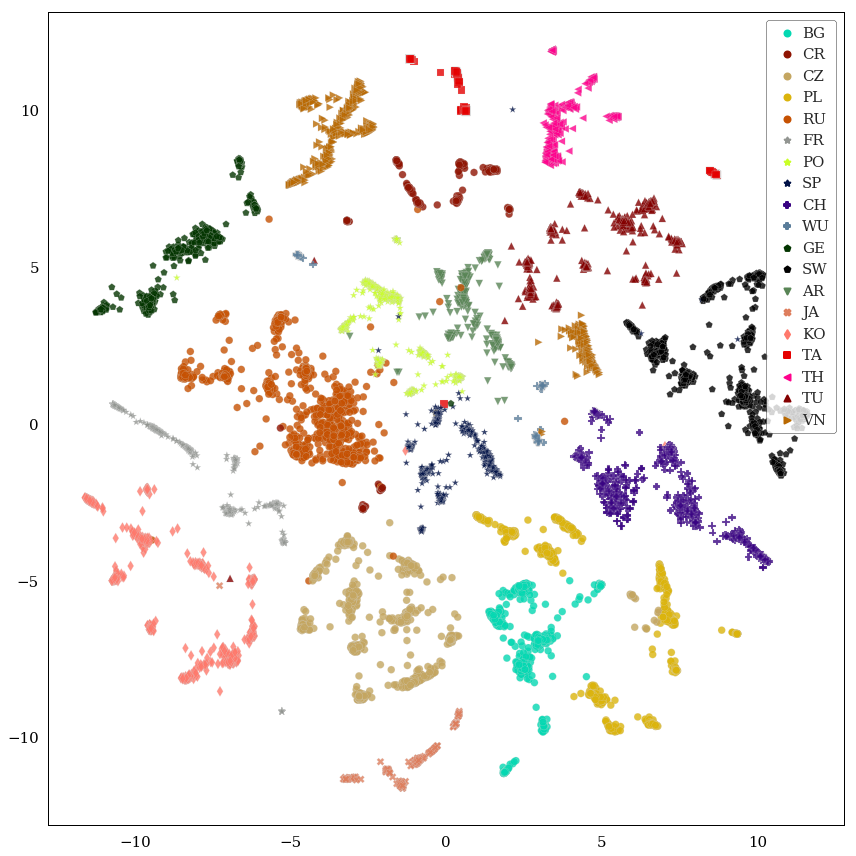

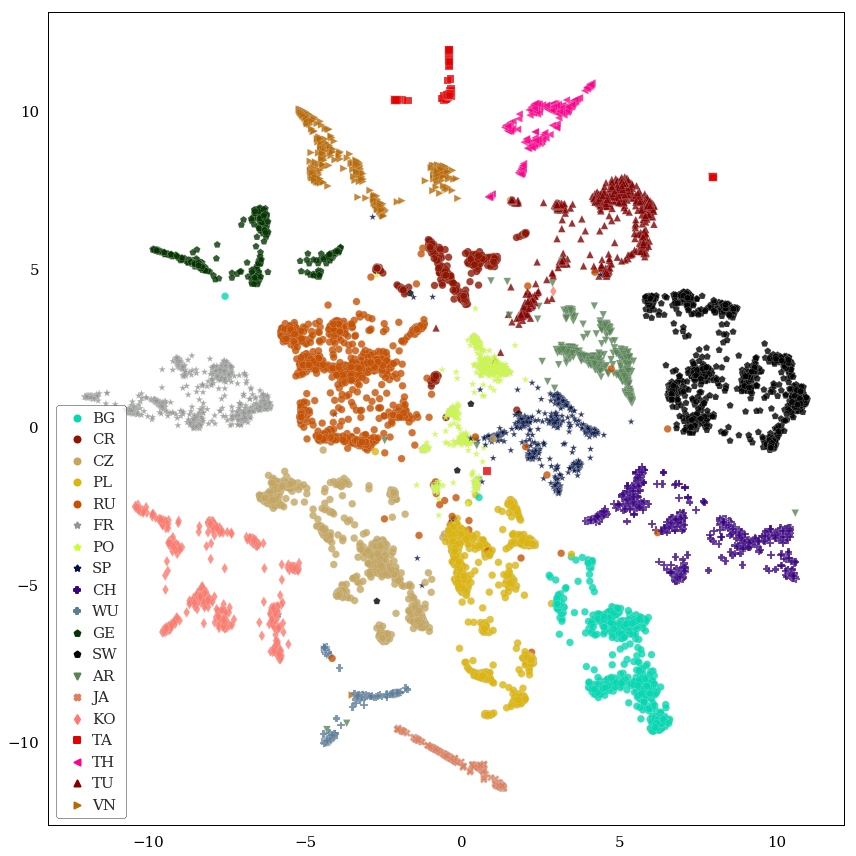

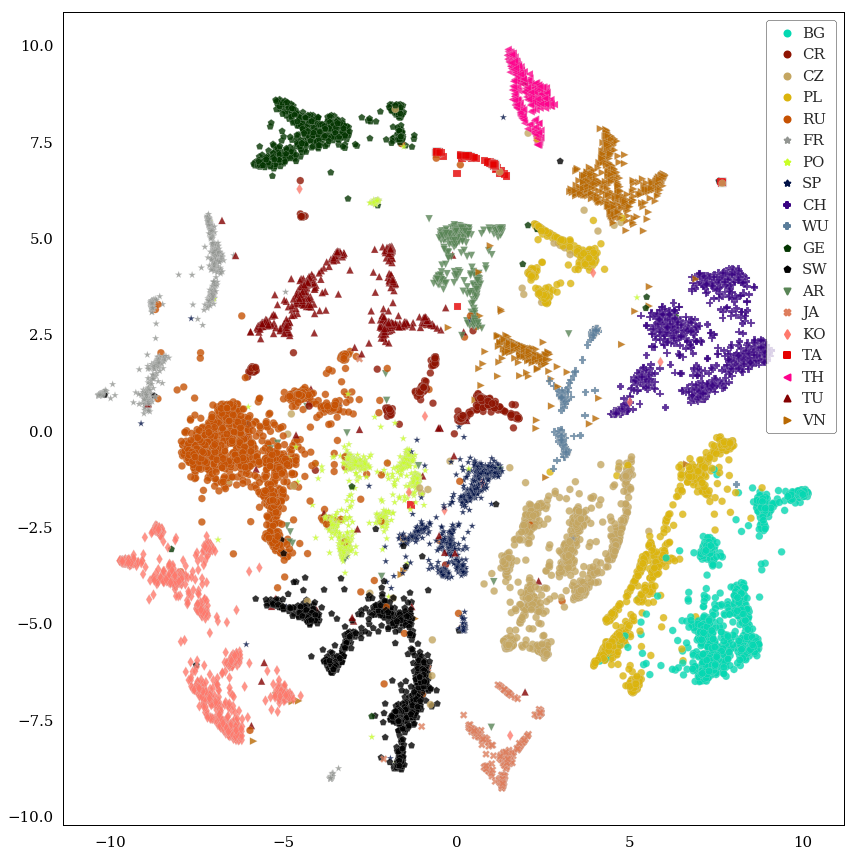

In [87]:
for exp in exps:
    fig = plot_tsne(data_to_plot[exp], lang_names=lang_names_by_family)
    graphing.save_fig(fig, name="tsne-{}".format(exp), dpi=150)
    plt.show()